TODO:
    * add image example to intro
    * add links: fast.ai, keras docs
    * check the on_epoch_end method: should it not return someth?
    * mention that blogpost is also available with runnable code on github
    * references: https://medium.com/@johnsondsouza23/export-keras-model-to-protobuf-for-tensorflow-serving-101ad6c65142
    * add someth on tf serving model directory
    * add someth on tf serving installation

# Blogpost: training and serving Tensorflow models with tf.Keras

# Intro

Keras is a high-level interface for neural networks that runs on top of multiple backends. It's functional API is **very user-friendly yet flexible enough** to do lots of cool stuff. Keras quickly gained traction after it's introduction and in 2017, the Keras API was integrated into core Tensorflow as tf.keras. Although tf.keras and Keras have separate code bases, they are tightly coupled and with the updated documentation and programmer guides as of Tensorflow 1.9, tf.keras is clearly the high level API to look for when wiring neural nets on top of Tensorflow. 

In this blogpost, we will work through the process of training, saving and serving a neural network with tf.keras. As an example, we will train a convolutional neural network on the Kaggle Planet dataset to predict labels for satellite images of the Amazon forest. This is not just a toy dataset, since the goal of the blogpost is to illustrate an end-to-end pipeline for a real-world use case.

1. Data preparation
2. Training the model with tf.keras.Sequence
3. Saving the model
4. Serving with tensorflow-serving

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# Data preparation

The data is available for download [here](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data). The training data consists of approximately 40000 labeled images of the Amazon rain forest. Each image is associated with: 
    * Exactly one out of four possible 'weather' labels: clear, haze, cloudy or partly cloudy
    * One or more out of 13 possible 'ground' labels: agriculture, bare_ground, habitation, road, water...  

I constructed a Pandas Dataframe with columns for the image names and the weather and ground labels encoded as one-hot binary vectors. The dataframe is available as a .csv file on my githhub:

In [2]:
import pandas as pd
df_train = pd.read_csv('./KagglePlanetMCML.csv')
df_train.head()

/home/stijn/venvs/blogpost/local/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/home/stijn/venvs/blogpost/local/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/home/stijn/venvs/blogpost/local/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/home/stijn/venvs/blogpost/local/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/home/stijn/venvs/blogpost/local/lib/py

,image_name,weather_labels,ground_labels
0,train_0,"[0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
1,train_1,"[1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]"
2,train_2,"[1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
3,train_3,"[1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,train_4,"[1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]"


The goal is to train a model that can accurately predict these labels for new images. We'll try to do this with a network that has two separate outputs for the weather and the ground labels. Predicting the weather labels is an example of a multi-class classification problem, whereas the ground labels can be modelled as a multi-label classification problem. Therefore, the loss function for both outputs will be different.

# Specifying the model

 Since this is a computer vision problem, we will use a convolutional neural network. As it turned out during the Kaggle competition, transfer learning with large pretrained networks was one of the keys to success. This is not the focus here, so we will build our own model from scratch. I'm going for a fairly classical configuration with some convolutional layers and relu activations and won't dwell on anything. For tips on how to achieve a top-of-the-leaderboard performance, check out the great fast.ai lecture that handles this dataset.

In [3]:
import tensorflow as tf
IM_SIZE = 16

image_input = tf.keras.Input(shape=(IM_SIZE, IM_SIZE, 3))

# Some convolutional layers
conv_1 = tf.keras.layers.Conv2D(32,
                                kernel_size=(3, 3),
                                padding='same',
                                activation='relu')(image_input)
conv_1 = tf.keras.layers.MaxPooling2D(padding='same')(conv_1)
conv_2 = tf.keras.layers.Conv2D(32,
                                kernel_size=(3, 3),
                                padding='same',
                                activation='relu')(conv_1)
conv_2 = tf.keras.layers.MaxPooling2D(padding='same')(conv_2)

# Flatten the output of the convolutional layers
conv_flat = tf.keras.layers.Flatten()(conv_2)

# Some dense layers with two separate outputs
fc_1 = tf.keras.layers.Dense(128,
                             activation='relu')(conv_flat)
fc_1 = tf.keras.layers.Dropout(0.2)(fc_1)
fc_2 = tf.keras.layers.Dense(128,
                             activation='relu')(fc_1)
fc_2 = tf.keras.layers.Dropout(0.2)(fc_2)

# Output layers: separate outputs for the weather and the ground labels
weather_output = tf.keras.layers.Dense(4,
                                       activation='softmax',
                                       name='weather')(fc_2)
ground_output = tf.keras.layers.Dense(13,
                                      activation='sigmoid',
                                      name='ground')(fc_2)

/home/stijn/venvs/blogpost/local/lib/python2.7/site-packages/h5py/__init__.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._conv import register_converters as _register_converters
/home/stijn/venvs/blogpost/local/lib/python2.7/site-packages/h5py/__init__.py:45: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import h5a, h5d, h5ds, h5f, h5fd, h5g, h5r, h5s, h5t, h5p, h5z
/home/stijn/venvs/blogpost/local/lib/python2.7/site-packages/h5py/_hl/group.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .. import h5g, h5i, h5o, h5r, h5t, h5l, h5p
/home/stijn/venvs/blogpost/local/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/home/stijn/venvs/blogpost/local/lib/python2.7/site-pa

We have two output layers, so these should be passed as a list of outputs when specifying the Model. Likewise, we can pass the two separate loss functions as a dictionary (or a list) when compiling the model. Conveniently, the tf.keras Model implementation comes with the extremely handy summary() method:

In [4]:
model = tf.keras.Model(inputs=image_input, outputs=[weather_output, ground_output])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 16, 3)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 8, 32)     0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 32)     9248        max_pooling2d[0][0]              
__________________________________________________________________________________________________
max_poolin

Upon compiling the model, the two different loss functions can be provided as a dictionary that maps tensor names to losses:

In [5]:
model.compile(optimizer='adam',
              loss={'weather': 'categorical_crossentropy',
                    'ground': 'binary_crossentropy'})

# Training the model

Let's train the model! I will be training this model on my laptop, which does not have enough RAM to take the entire dataset into memory. With image data, this is very often the case. Keras provides the ```fit_generator()``` method that can use a custom Python generator yielding images from disc for training. However, as of Keras 2.0.6, we can use the ```Sequence``` object instead of a generator which allows for safe multiprocessing which means significant speedups and less risk of bottlenecking your GPU if you have one. The Keras documentation already provides good example code, which I will customize a bit to:
* make it work with a dataframe that maps image names to labels
* shuffle the training data after every epoch
* handle a final batch that is smaller than the actual batch size

In [6]:
import ast
import os
import numpy as np
import random
from math import ceil
from tensorflow.keras.preprocessing.image import img_to_array as img_to_array
from tensorflow.keras.preprocessing.image import load_img as load_img

In [7]:
class KagglePlanetSequence(tf.keras.utils.Sequence):
    """
    Custom Sequence object to train a model on out-of-memory datasets. 
    """
    def __init__(self, df_path, data_path, im_size, batch_size, mode='train'):
        """
        df_path: path to a .csv file that contains columns with image names and labels
        data_path: path that contains the training images
        im_size: image size
        mode: when in training mode, data will be shuffled between epochs
        """
        self.df = pd.read_csv(df_path).iloc[:500,:]
        self.dp = data_path
        self.imsz = im_size
        self.bsz = batch_size
        self.mode = mode

        # Take labels and a list of image locations in memory
        self.wlabels = [ast.literal_eval(v) for v in self.df['weather_labels'].values]
        self.glabels = [ast.literal_eval(v) for v in self.df['ground_labels'].values]
        self.im_list = [os.path.join(self.dp, im + '.jpg') for im in self.df['image_name'].values]

    def __len__(self):
        return ceil(len(self.df) / self.bsz)

    def on_epoch_end(self):
        # Shuffles indexes after each epoch
        self.indexes = range(len(self.im_list))
        if self.mode == 'train':
            self.indexes = random.sample(self.indexes, k=len(self.indexes))

    def get_batch_labels(self, idx):
        if idx == self.__len__() / self.bsz:
            return [self.wlabels[idx * self.bsz:], self.glabels[idx * self.bsz:]]
        return [self.wlabels[idx * self.bsz: (idx + 1) * self.bsz], self.glabels[idx * self.bsz: (idx + 1) * self.bsz]]

    def get_batch_features(self, idx):
        if idx == self.__len__() / self.bsz:
            return [img_to_array(load_img(im, target_size=(self.imsz, self.imsz))) / 255. for im in self.im_list[idx * self.bsz:]]
        return np.array([img_to_array(load_img(im, target_size=(self.imsz, self.imsz))) / 255. for im in self.im_list[idx * self.bsz: (1 + idx) * self.bsz]])

    def __getitem__(self, idx):
        batch_x = self.get_batch_features(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_x, batch_y
    
BATCH_SIZE = 32
seq = KagglePlanetSequence('./KagglePlanetMCML.csv',
                       './data/train/',
                       im_size=IM_SIZE,
                       batch_size=32)

This ```Sequence``` object can be used instead of a custom generator together with ```fit_generator()``` to train the model. ```tf.keras``` provides access to all the Keras Callbacks that enhance the training loop. If you evaluate the after each epoch on validation data (which you should do), these can be quite powerful and provide options for early stopping, storing only that version of the model that does not overfit et cetera. Here, we will use the ModelCheckPoint callback just to save the model after every epoch so that we can pick up training afterwards if we want. By default, the model architecture, training configuration, state of the optimizer and the weights are stored, such that the entire model can be recreated from a single file.

Let's train the model for 3 epochs!

In [13]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./model_weights.h5',verbose=1, save_weights_only=True),
    tf.keras.callbacks.ModelCheckpoint('./model.h5', verbose=1)
]

model.fit_generator(generator=seq,
                    verbose=1, 
                    epochs=2,
                    use_multiprocessing=True,
                    workers=4,
                    callbacks=callbacks)

Epoch 1/2
14/15 [===========================>..] - ETA: 0s - loss: 0.9362 - weather_loss: 0.7047 - ground_loss: 0.2316
Epoch 00001: saving model to ./model_weights.h5

Epoch 00001: saving model to ./model.h5
15/15 [==============================] - 1s 61ms/step - loss: 0.9289 - weather_loss: 0.7005 - ground_loss: 0.2284
Epoch 2/2
12/15 [=======================>......] - ETA: 0s - loss: 0.9007 - weather_loss: 0.6728 - ground_loss: 0.2279
Epoch 00002: saving model to ./model_weights.h5

Epoch 00002: saving model to ./model.h5
15/15 [==============================] - 1s 61ms/step - loss: 0.9176 - weather_loss: 0.6903 - ground_loss: 0.2272


Suppose that we want to finetune the model in a later stage, we can simply read the model file and pick up training even without explicitly recompiling:

In [14]:
another_model = tf.keras.models.load_model('./model.h5')
another_model.fit_generator(generator=seq,
                    verbose=1, 
                    epochs=2)

Epoch 1/2
15/15 [==============================] - 2s 108ms/step - loss: 0.8870 - weather_loss: 0.6631 - ground_loss: 0.2239
Epoch 2/2
15/15 [==============================] - 2s 105ms/step - loss: 0.9127 - weather_loss: 0.6868 - ground_loss: 0.2260


Note the increase of the training time when multiprocessing is disabled.

# Exporting the model

Now that we have a trained model, want to export it for serving.

In [15]:
import tensorflow as tf
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model.signature_def_utils_impl import predict_signature_def
from tensorflow.python.saved_model import tag_constants

tf.keras.backend.set_learning_phase(0)    
model = tf.keras.models.load_model('./model.h5')
export_path = './models/1'

builder = saved_model_builder.SavedModelBuilder(export_path)
signature = predict_signature_def(inputs={'images': model.input},
                    outputs={t.name:t for t in model.outputs})    
key = tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY

with tf.keras.backend.get_session() as sess:
    builder.add_meta_graph_and_variables(sess=sess,
                                 tags=[tag_constants.SERVING],
                                 signature_def_map={key: signature})
    
    builder.save()   

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./models/1/saved_model.pb


# 4. Host and call the model server

 A good option is [TensorFlow Serving](https://www.tensorflow.org/serving/):
> TensorFlow Serving is a flexible, high-performance serving system for machine learning models, designed for production environments. 

```Servables``` are the key object in TensorFlow serving. Apart from that, TF Serving provides Loaders and Managers that handle the actual serving, loading of new versions and unloading of old versions.

As of TensorFlow serving 1.9, it's possible to make call a hosted model via either gRPC or a REST request. There are quite some tutorials online on how to make gRPC request, we will try doing a REST request here. 

First of all, I'd like to highlight TensorFlow's `SavedModel` command line tool, which is useful to quickly inspect the input and output specifications of our Model:

```
$ saved_model_cli show --dir ./ --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['images'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 16, 16, 3)
      name: input_1_5:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['ground_5/Sigmoid:0'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 13)
      name: ground_5/Sigmoid:0
  outputs['weather_5/Softmax:0'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 4)
      name: weather_5/Softmax:0
Method name is: tensorflow/serving/predict
```


We even have access to ```numpy``` within the CLI (as ```np```) to send some random input to the model to verify that it works:

```
$ saved_model_cli run --dir ./ --tag_set serve --signature_def serving_default --input_exp 'images=np.random.rand(1,16,16,3)'

Result for output key ground_5/Sigmoid:0:
[[1.2893094e-01 6.4332830e-04 1.3402618e-03 7.4971933e-04 3.6600672e-05
  1.3365776e-04 2.2603733e-02 1.7313704e-02 9.9981135e-01 8.8962197e-02
  4.4833246e-04 2.0555612e-04 8.2832985e-02]]
Result for output key weather_5/Softmax:0:
[[9.3750894e-01 1.9014442e-06 1.9851823e-05 6.2469237e-02]]

```

Seems to work. Let's host the model from the model directory (some of the output below is truncated for visibility):

```
$ tensorflow_model_server --model_base_path=$(pwd) --rest_api_port=9000 --model_name=models

...
I tensorflow_serving/core/basic_manager] Successfully reserved resources to load servable {name: models version: 1}
I tensorflow_serving/core/loader_harness] Approving load for servable version {name: models version: 1}
I tensorflow_serving/core/loader_harness] Loading servable version {name: models version: 1}
I external/org_tensorflow/tensorflow/cc/saved_model/loader] SavedModel load for tags { serve }; Status: success. Took 883423 microseconds.
I tensorflow_serving/core/loader_harness] Successfully loaded servable version {name: models version: 1}
...
I tensorflow_serving/model_servers/main] Exporting HTTP/REST API at:localhost:9000 ...

```

Finally, we can send requests to our server via the python `request` module:   

In [66]:
import requests
import json

image = img_to_array(load_img('./data/train/train_10001.jpg', target_size=(16,16))) / 255.
payload = {
  "instances": [{'images': image.tolist()}]
}
r = requests.post('http://localhost:9000/v1/models/models:predict', json=payload)

In [67]:
json.loads(r.content)

{u'predictions': [{u'ground_2/Sigmoid:0': [0.227877,
    0.00829674,
    0.0240078,
    0.00906727,
    0.00227873,
    0.00150585,
    0.0815054,
    0.0819165,
    0.994118,
    0.146202,
    0.0131724,
    0.00499781,
    0.125618],
   u'weather_2/Softmax:0': [0.906566, 0.000451428, 0.00264539, 0.0903377]}]}

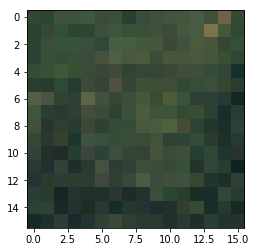

In [68]:
fig, ax = plt.subplots()
ax.imshow(image)